In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ

%matplotlib inline

Using TensorFlow backend.


In [2]:
from sklearn.externals import joblib

In [3]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '0'

import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Lambda
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
# from keras.losses import mse, binary_crossentropy
from keras.objectives import binary_crossentropy
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Считаем подготовленные для обучения автоэнкодера данные

In [5]:
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests

df = pd.read_csv('../Data/LHCb_PID_obscured.csv')

In [6]:
df.head()

,pid,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,...,S4x1,S4x2,S3x2,S4x3,S4x4,S5x1,S5x2,S5x3,S5x4,S4x5
0,a,1.0,1.0,1.0,12.470869,16.0,1.498864,4.0,0.0,0.0,...,43124.0,1.0,4497.850098,1696.200195,0.195356,1.046679,538.357971,35546.0,1.0,655.779785
1,f,1.0,-999.0,-999.0,2.611352,6.0,8.613868,9.0,-999.0,-999.0,...,-999.0,-999.0,-999.000000,-999.000000,-999.000000,0.942609,745.686462,35684.0,0.0,-999.000000
2,c,1.0,1.0,1.0,15.694536,17.0,5.911904,7.0,1.0,1.0,...,35553.0,1.0,566.271973,1401.664062,0.538877,0.841611,811.178467,35799.0,0.0,-2616.123047
3,d,-999.0,1.0,1.0,12.244493,14.0,2.455816,3.0,0.0,0.0,...,39028.0,1.0,4894.333984,85.869995,1.656766,-999.000000,-999.000000,-999.0,-999.0,230.555283
4,c,1.0,-999.0,-999.0,22.676029,19.0,4.777353,5.0,-999.0,-999.0,...,-999.0,-999.0,-999.000000,-999.000000,-999.000000,0.968089,1529.644287,34142.0,1.0,-999.000000


In [7]:
# df = df[df["pid"] != 'c']

In [8]:
# How many samples of each particle do we have
print(df['pid'].value_counts())

f    545384
b    545384
e    545384
d    545384
c    545384
a    545384
Name: pid, dtype: int64


In [9]:
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [10]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

35 variables to compress


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 3min 31s, sys: 16.2 s, total: 3min 48s
Wall time: 15.8 s


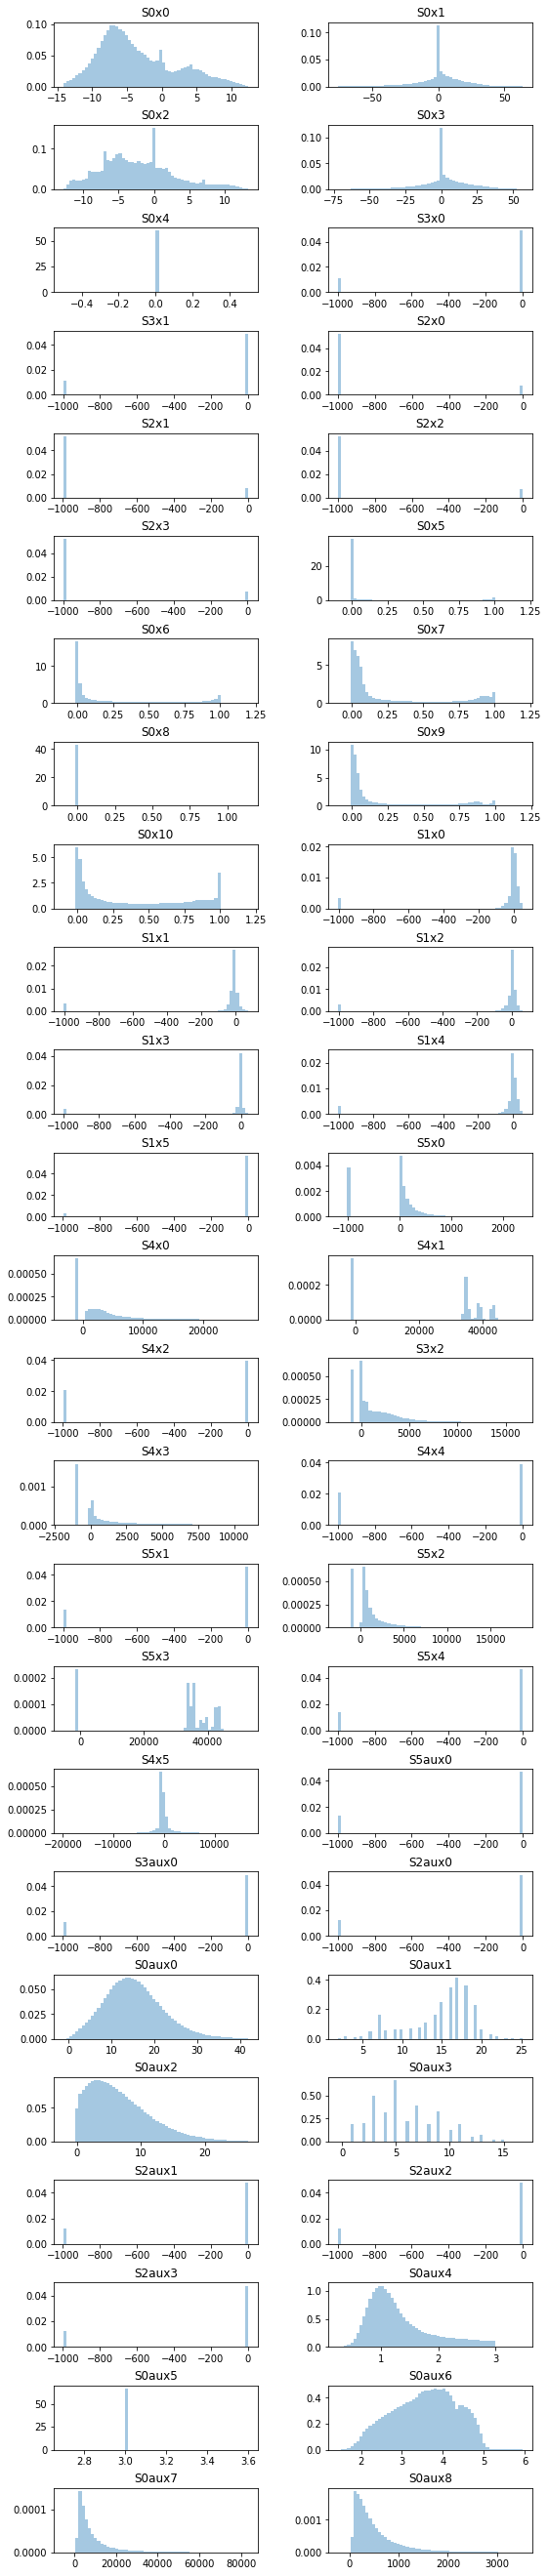

In [11]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./img/original_distribs.png")

# Разобъем индексы на train и test

In [12]:
# train test split
xgb_size = 0.1
data_size = 0.9
idx_xgb, idx_data = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=xgb_size, test_size=data_size)

In [13]:
xgb_data = df.iloc[idx_xgb]
df = df.iloc[idx_data]

In [14]:
len(idx_xgb)

327230

In [15]:
# train test split
train_size = 0.4
test_size = 0.6
idx_train, idx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=train_size, test_size=test_size)

In [16]:
df.shape, idx_train.shape, idx_test.shape

((2945074, 51), (1178029,), (1767045,))

## Переведем значения признаков в отрезок $[0, 1]$

Ранее помимо масштабирования признаков меняли и их распределение на равномерное, но это не имеет смысла, так как энкодер и декодер восстанавливают распределения $P(Z|X)$ и $Q(X|Z)$ соответственно. А по ним уже восстанавливается распределение $P(X)$ каким бы оно не было.

##### Так то оно правильно, но, может быть, автоэнкодеру проще восстановить равномерное распределение, чем произвольное?!

In [17]:
df_scaled = df.copy()

In [18]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
    # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(df[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = std_scaler.transform(df[var].values.reshape(-1, 1))
    
    # normalize with MaxAbsScaler
    max_scaler = MinMaxScaler()
    max_scaler.fit(df_scaled[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = max_scaler.transform(df_scaled[var].values.reshape(-1, 1))
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }

CPU times: user 4min, sys: 43.2 s, total: 4min 43s
Wall time: 13.6 s


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


CPU times: user 2min 57s, sys: 11.8 s, total: 3min 9s
Wall time: 13.5 s


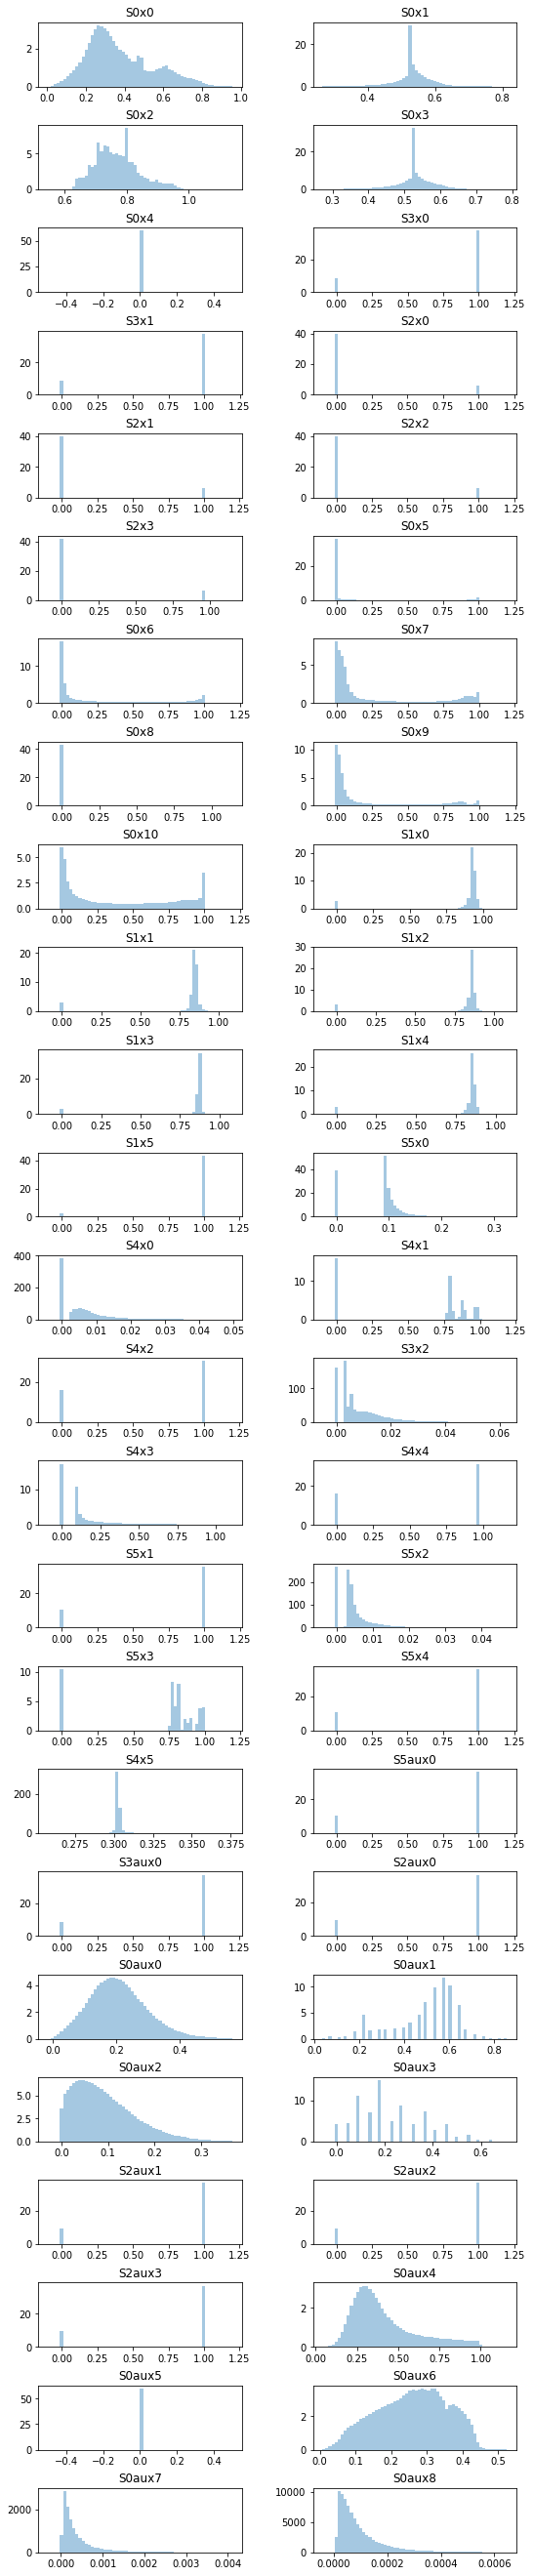

In [28]:
%%time
# Display histograms of our features
print_features_histograms(df_scaled[vars_list_input + vars_list_aux], None, save_filename="./img/scaled_distribs.png")

## Зададим архитектуру автоэнкодера

In [56]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5*z_log_var) * epsilon

def create_vae_aux(n_features, encoding_dim, n_aux_features=5, n_mc_features=6, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    
    x = keras.layers.concatenate([inputs, aux_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
#         x = keras.layers.concatenate([x, aux_inputs])

    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = keras.layers.concatenate([x, aux_inputs])

    encoded_mu = Dense(encoding_dim, activation='tanh', name='encoded_mu')(x)
    encoded_sigma = Dense(encoding_dim, activation='tanh', name='encoded_sigma')(x)
    encoded = Lambda(sampling, output_shape=(encoding_dim,), name='encoded')([encoded_mu, encoded_sigma])

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    
    for i in range(n_layers - 1):
#         x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)
        
    decoded = Dense(n_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], [encoded_mu, encoded_sigma, encoded], name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    
    outputs = decoder([encoder([inputs, aux_inputs])[2], aux_inputs])
    autoencoder = Model(
        [inputs, aux_inputs], outputs, name="autoencoder"
    )

    optimizer_adam = optimizers.Adam(lr=0.001)
    
    reconstruction_loss = binary_crossentropy(inputs, outputs)
    reconstruction_loss *= n_features
    kl_loss = 1 + encoded_sigma - K.square(encoded_mu) - K.exp(encoded_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss) 
    autoencoder.add_loss(vae_loss)
    autoencoder.compile(optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

## Обучим автоэнкодер

In [57]:
l_encoding_dim = [6]

In [31]:
l_score = []
val_size = 0.2

train = df_scaled.iloc[idx_train]
test = df_scaled.iloc[idx_test]

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
le = LabelBinarizer()

train_input = train[vars_list_input].values
train_aux   = train[vars_list_aux].values
train_MC    = train[vars_list_MC].values.ravel()

# le.fit(train_MC)
# train_MC = le.transform(train_MC)

test_input = test[vars_list_input].values
test_aux   = test[vars_list_aux].values
test_MC    = test[vars_list_MC].values.ravel()
# test_MC = le.transform(test_MC)

In [58]:
%%time
nb_epoch = 50
batch_size = 128
n_layers = 4
thickness = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, mode='min')
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}   
    
for encoding_dim in tqdm(l_encoding_dim):
    print("encoding_dim : ", encoding_dim)

    autoencoder, encoder, decoder = create_vae_aux(
        train_input.shape[1], encoding_dim, 
        n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness
    )
    
    checkpointer = keras.callbacks.ModelCheckpoint(
                    filepath="vae_bc_ratio60_{}.hdf5".format(encoding_dim), 
                    verbose=0, 
                    save_best_only=True)

    history = autoencoder.fit(
        [train_input, train_aux], 
        epochs=nb_epoch, batch_size=batch_size,
        shuffle=True, verbose=1,
        validation_split=val_size, callbacks =[early_stopping, tensorboard, checkpointer]
    )
    
    autoencoder.load_weights("vae_bc_ratio60_{}.hdf5".format(encoding_dim))

    score = autoencoder.evaluate([test_input, test_aux], batch_size=batch_size)
    # print ("\n\nscore : ", score)
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux])
    decoded_test = decoder.predict([encoded_test[2], test_aux]) # test mode = 0
#     print_features_histograms(pd.DataFrame(decoded_test), target=pd.DataFrame(test_input))

    save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
    save_encoded_dict[encoding_dim] = np.array(encoded_test).astype(np.float64)

#     plt.clf()
    plt.plot(history.history['loss'], "b")
    plt.plot(history.history['val_loss'], "r")
    plt.ylim(0, 0.04)
#     plt.xlim(0, 40)
    print("\n\n")




  0%|          | 0/1 [00:00<?, ?it/s]

encoding_dim :  6
Train on 942423 samples, validate on 235606 samples
Epoch 1/50
942423/942423 [==============================] - 350s 372us/step - loss: 152.1783 - val_loss: 169.9476
Epoch 2/50
942423/942423 [==============================] - 349s 370us/step - loss: 169.5654 - val_loss: 169.3501
Epoch 3/50
698752/942423 [=====================>........] - ETA: 1:27 - loss: 169.0587

KeyboardInterrupt: 

In [26]:
test[vars_list_aux+["pid"]].to_csv("aux_test_old.csv")

In [27]:
test[vars_list_aux+["pid"]].head()

,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,pid
806680,0.284772,0.223544,0.259309,-0.146963,-0.060651,0.002035,0.202037,0.259122,0.259099,0.25913,0.214215,0.0,-0.005001,0.000157,0.000243,f
1433017,0.284772,0.223544,0.259309,-0.001203,0.151479,0.088446,0.202037,0.259122,0.259099,0.25913,0.584757,0.0,-0.040925,-0.000202,-0.000117,b
2233113,0.284772,0.223544,0.259309,-0.073936,0.080769,-0.064423,0.202037,0.259122,0.259099,0.25913,-0.161087,0.0,-0.017079,-0.000268,-0.000267,b
2013487,-1.000000,0.223544,0.259309,0.050440,0.151479,-0.082189,-0.196945,0.259122,0.259099,0.25913,-0.150745,0.0,0.150000,0.000073,-0.000297,b
2532583,0.284772,0.223544,0.259309,0.015057,-0.202071,0.023196,0.069043,0.259122,0.259099,0.25913,0.269076,0.0,0.066359,-0.000093,-0.000249,b


In [47]:
from collections import defaultdict

test_inpits = defaultdict(list)
test_auxs = defaultdict(list)
for x, (y, z) in zip(test_input, zip(test_aux, test_MC)):
    test_inpits[z].append(x)
    test_auxs[z].append(y)

In [48]:
encoded = {}
y = []
for i, pid in enumerate(test_inpits.keys()):
    encoded[pid] = encoder.predict([test_inpits[pid][:1000], test_auxs[pid][:1000]])
    y.extend([i]*1000)

In [49]:
encoded_values = np.concatenate(list(encoded.values()), axis=1)

In [50]:
encoded_values.shape

(3, 6000, 3)

In [51]:
np.array(y)

array([0, 0, 0, ..., 5, 5, 5])

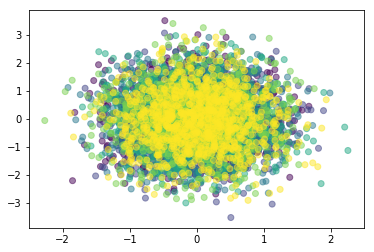

In [52]:
plt.scatter(encoded_values[2][:, 1], encoded_values[2][:, 2], c=np.array(y), alpha=0.5)
plt.show()

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

## Сохраненим score, сжимаемые переменные, test и decoded(после обратного масштабирования)

In [33]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict'] = save_encoded_dict
retain_dict['test_input'] = test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score[1:]
retain_dict['vars_list_input'] = vars_list_input

In [34]:
test_input_unslaced = test_input.copy()
test_aux_unslaced = test_aux.copy()

In [35]:
# %%time
for i, var in enumerate(vars_list_input):
    test_input_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_input[:, i].reshape(-1, 1))
    ).reshape(-1)
    
for i, var in enumerate(vars_list_aux):
    test_aux_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_aux[:, i].reshape(-1, 1))
    ).reshape(-1)

retain_dict['test_input_dec'] = test_input_unslaced
retain_dict['test_aux_dec'] = test_aux_unslaced

In [36]:
save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    tmp_decoded_unscaled = save_decoded_dict[encoding_dim].copy()
    for i, var in enumerate(vars_list_input):
        tmp_decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(tmp_decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
    save_decoded_dict_dec[encoding_dim] = tmp_decoded_unscaled

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [32]:
for i, var in enumerate(vars_list_input + vars_list_aux):
    joblib.dump(scalers[var]['std'], os.path.join('preprocessors', "VAE_scaler_std_"+var) + ".pkl")
    joblib.dump(scalers[var]['max'], os.path.join('preprocessors', "VAE_scaler_max_"+var) + ".pkl")

In [33]:
pickle.dump(retain_dict, open("VAE_retain_dict_old_{}.p".format(TYPE), "wb"))

In [34]:
for encoding_dim in l_encoding_dim:
#     df_temp_enc = pd.DataFrame(save_encoded_dict[encoding_dim])
#     df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, df[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']].iloc[idx_test]], axis=1), columns=list(range(encoding_dim))+['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
#     df_temp_full_enc.to_csv("VAE_df_old_encoded_ratio10_{}.csv".format(encoding_dim))
    np.save("VAE_encoded", save_encoded_dict[encoding_dim])
    
    df_temp_dec = pd.DataFrame(save_decoded_dict_dec[encoding_dim], columns=vars_list_input)
    df_temp_full_dec = pd.DataFrame(np.concatenate([df_temp_dec, df[['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']].iloc[idx_test]], axis=1), columns=vars_list_input+['pid', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
    df_temp_full_dec.to_csv("VAE_df_old_decoded_ratio10_{}.csv".format(encoding_dim))

## Посмотрим на результаты работы автоэнкодеров

Загрузка сохраненных данных

In [37]:
#Load Output from Neural Network training
TYPE = "" # 100% of the data. To determine the real performance of the cross check
#TYPE = "_10perc" #10% of the data. Used for everything except to determine the real performance of the cross check
#TYPE = "_1perc" #1% of the data. For small tests.
#TYPE = "_100" #100 samples of the data. For very rudimentary tests

pids = ['a', 'b', 'c', 'd', 'e']

# retain_dict = pickle.load( open( "VAE_retain_dict_old_{}.p".format(TYPE), "rb" ) )
test_input = retain_dict.pop("test_input")
test_input_dec = retain_dict.pop("test_input_dec")
test_aux = retain_dict.pop("test_aux")
test_MC = retain_dict.pop("test_MC")
l_score = retain_dict.pop("l_score")
save_decoded_dict = retain_dict.pop("save_decoded_dict")
save_decoded_dict_dec = retain_dict.pop("save_decoded_dict_dec")
vars_list_input = retain_dict.pop("vars_list_input")

l_encoding_dim = list(save_decoded_dict.keys())

******************** 3 ********************


/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


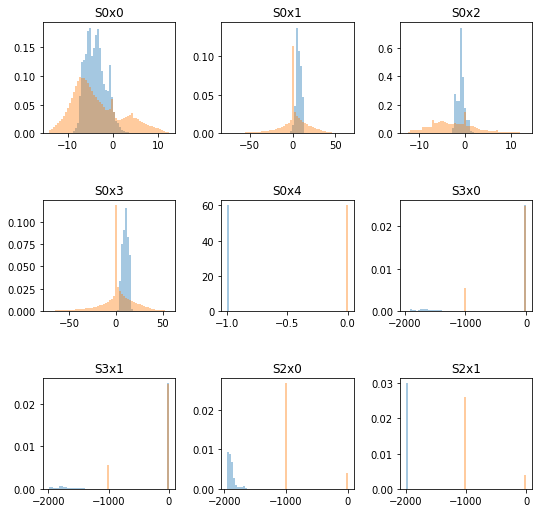

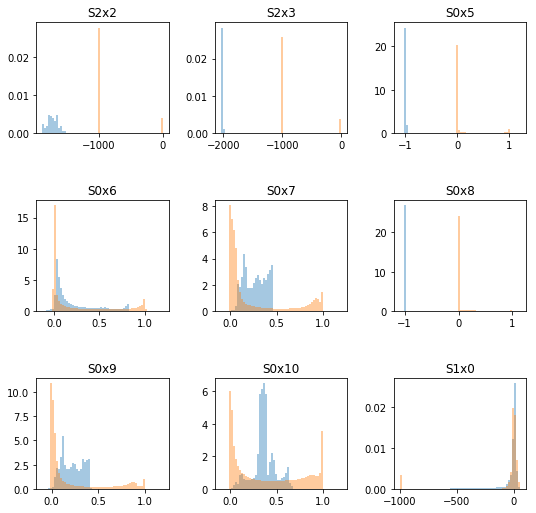

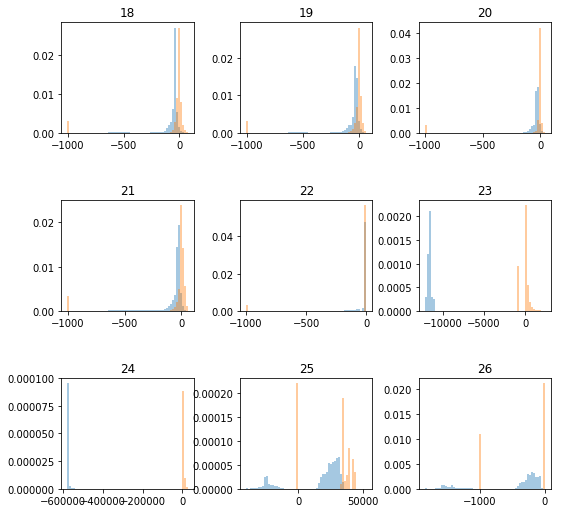

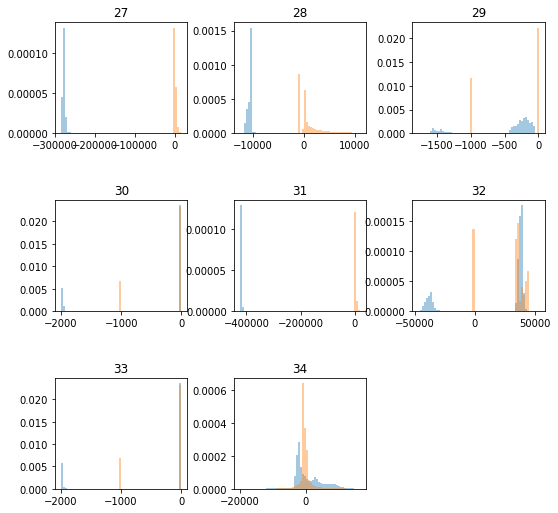

******************** 6 ********************


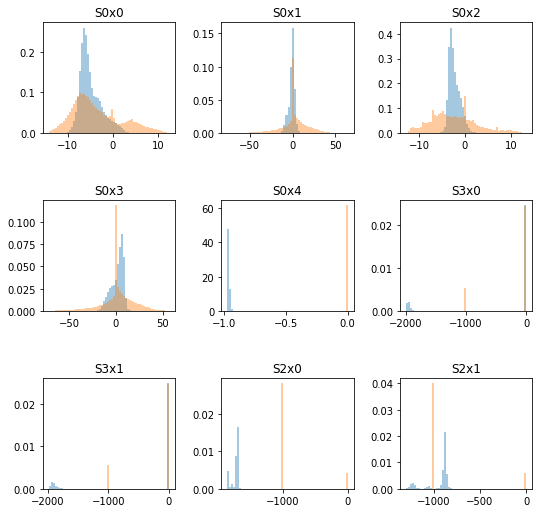

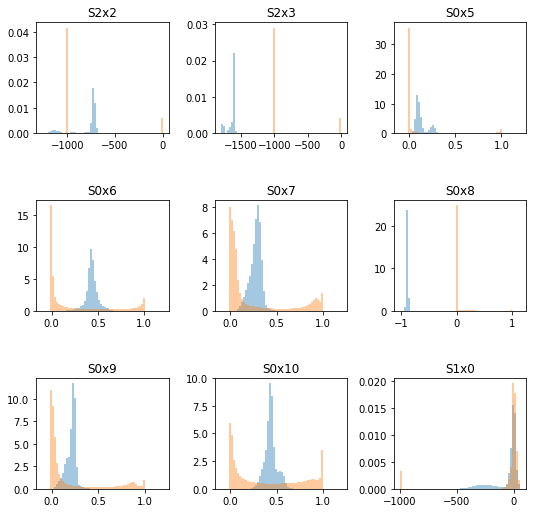

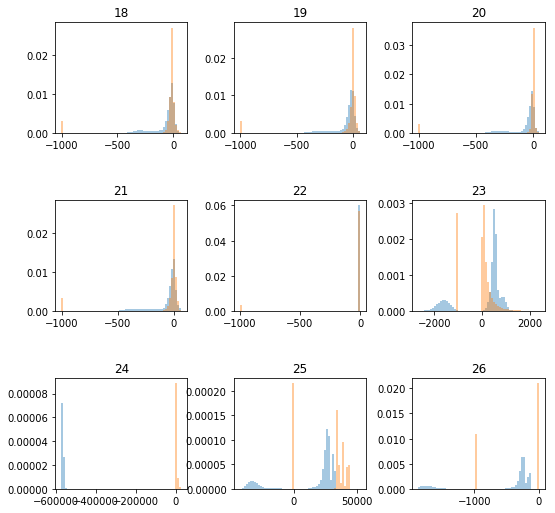

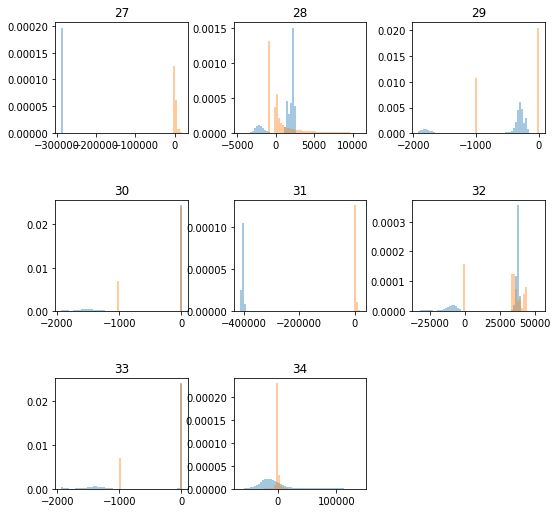

In [38]:
# The following plots show the orignal distributions in orange and the decoded distributions in blue.
# If the autoencoder has not lost a lot of information, these should lie on top of each other

rename_dict = {}
for i, e in enumerate(range(18)):
    rename_dict[e] = vars_list_input[i]
    
    
for encoding_dim in l_encoding_dim:
    # if you don't care about the names of the features uncomment the following line
#     print_features_histograms(
#         pd.DataFrame(save_decoded_dict_dec[encoding_dim]), 
#         target=pd.DataFrame(test_input_dec)
#     )
    print('*' * 20, encoding_dim, '*' * 20)
    
    df_temp = pd.DataFrame(save_decoded_dict_dec[encoding_dim])
    df_temp_input = pd.DataFrame(test_input_dec)

    df_temp.rename(columns=rename_dict, inplace=True)
    df_temp_input.rename(columns=rename_dict, inplace=True)

    print_features_histograms_displ(
        df_temp, target=df_temp_input, 
        save_filename="_VAE_{1}_orig_uncom_distribs_{0}.png".format(TYPE, encoding_dim)
    )
    plt.show()

Зависимость MSE от encoding_dim

** Этапы: **
- Подготовка данных для обучения и их сохранение


- Разбиение на train и test
- Масштабирование данных(обучая на train)
- Задание архитектуры автоэнкодера
- Его обучение
- Вычисление score, encoded, decoded
- Обратное масштабирование данных(test, decoded)
- Сохранение score, сжимаемые переменные, test и decoded(после обратного масштабирования)


- Гистограммы распределений
- Зависимость MSE от encoding_dim


- Обучение классификаторов на test/decoded
- Вычисление метрик качества(ROC AUC, PR AUC, F-measure)
- Сохранение их
- Построение графиков

# Тестирование автоэнкодера на задаче классификации

### sampling from VAE

In [40]:
xgb_input = xgb_data[vars_list_input].values
xgb_aux   = xgb_data[vars_list_aux].values
xgb_MC    = xgb_data[vars_list_MC].values

In [42]:
le = LabelEncoder()
y = le.fit_transform(xgb_MC[:, 0])

In [43]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(xgb_input.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = xgb_input[idx_train_clf], xgb_input[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

X_train_aux, X_test_aux = xgb_aux[idx_train_clf], xgb_aux[idx_test_clf]

In [45]:
orig_test_old = pd.DataFrame(np.concatenate([X_test, X_test_aux], axis=1), columns=vars_list_input+vars_list_aux)
orig_test_old["pid"] = y_test
orig_test_old.to_csv("orig_test_old.csv")

scalers = {var: {} for var in vars_list_input+vars_list_aux}
for i, var in enumerate( vars_list_input+vars_list_aux):
    scalers[var]['std'] = joblib.load(os.path.join('preprocessors', "VAE_scaler_std_"+var) + ".pkl")
    scalers[var]['max'] = joblib.load(os.path.join('preprocessors', "VAE_scaler_max_"+var) + ".pkl")

orig_test_old_scaled = orig_test_old.copy()
for var in (vars_list_input + vars_list_aux):
    orig_test_old_scaled[var] = scalers[var]["std"].transform(orig_test_old[var].values.reshape(-1, 1))
    orig_test_old_scaled[var] = scalers[var]["max"].transform(orig_test_old_scaled[var].values.reshape(-1, 1))

In [75]:
from collections import defaultdict
samples = {}
samples_y = {}

for enc_dim in l_encoding_dim:
    autoencoder, encoder, decoder = create_vae_aux(
        train_input.shape[1], enc_dim, 
        n_aux_features=train_aux.shape[1],
        n_layers=n_layers, thickness=thickness
    )
    autoencoder.load_weights("model_old_ratio10_{}.hdf5".format(enc_dim))
    
    latent_var = [np.random.normal(0, 1, enc_dim) for i in range(len(orig_test_old_scaled))]
    decoded_test = decoder.predict([latent_var, orig_test_old_scaled[vars_list_aux].values])
    
    decoded_unscaled = decoded_test.copy()
    for i, var in enumerate(vars_list_input):
        decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
        
    samples[enc_dim] = decoded_unscaled  
    samples_y[enc_dim] = orig_test_old_scaled[vars_list_MC].values
      
#     pd.DataFrame(
#         np.concatenate([decoded_unscaled, orig_test_old_scaled[vars_list_aux].values], axis=1),
#         columns=vars_list_input+vars_list_aux
#     ).to_csv('vae_test_pid_{}_old.csv'.format(encoding_dim))

In [50]:
from helpers import *

In [51]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', 'f'], dtype=object)

In [52]:
xgb_input.shape, y.shape, xgb_MC.shape, xgb_data.shape

((327230, 35), (327230,), (327230, 1), (327230, 51))

In [53]:
path_to_metrics = './metrics/'
metrics_dir_name = "vae_old"

In [54]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

---------------------

In [55]:
clf_name = "XGBoost_old_{}".format(9)
clf = xgb.XGBClassifier(nthread=-1, seed=111)
# clf.fit(X_train, y_train)
# joblib.dump(clf, os.path.join('xgboost', clf_name) + ".pkl")
clf = joblib.load(os.path.join('xgboost', clf_name) + ".pkl")

In [73]:
samples_y = le.transform(test_MC)

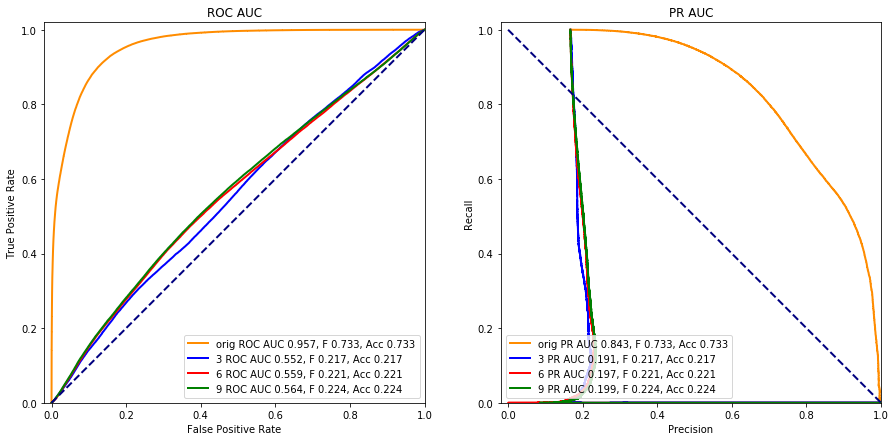

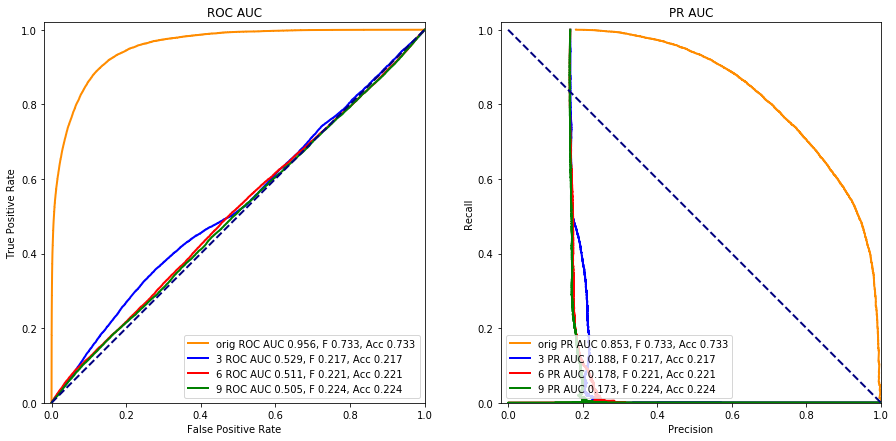

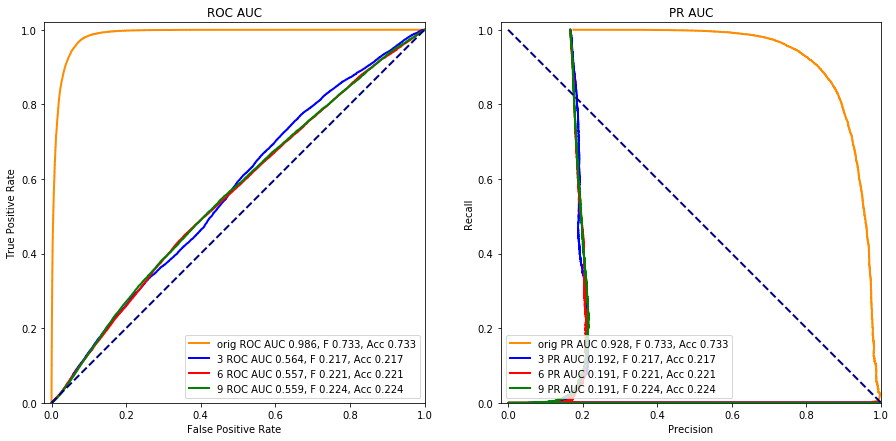

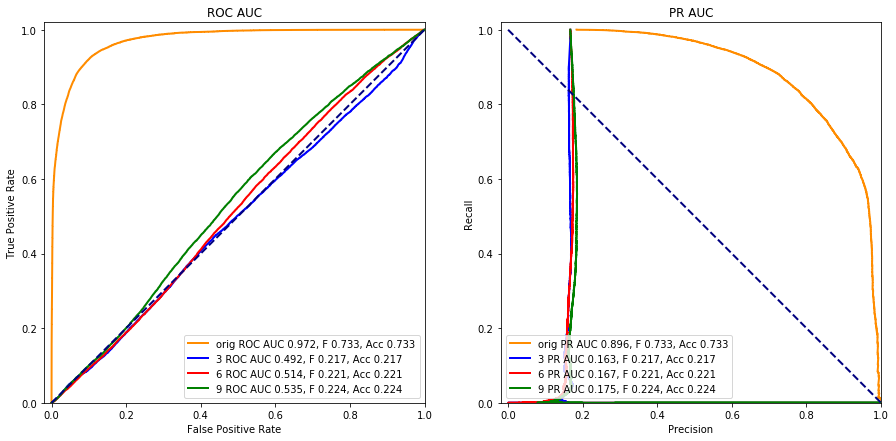

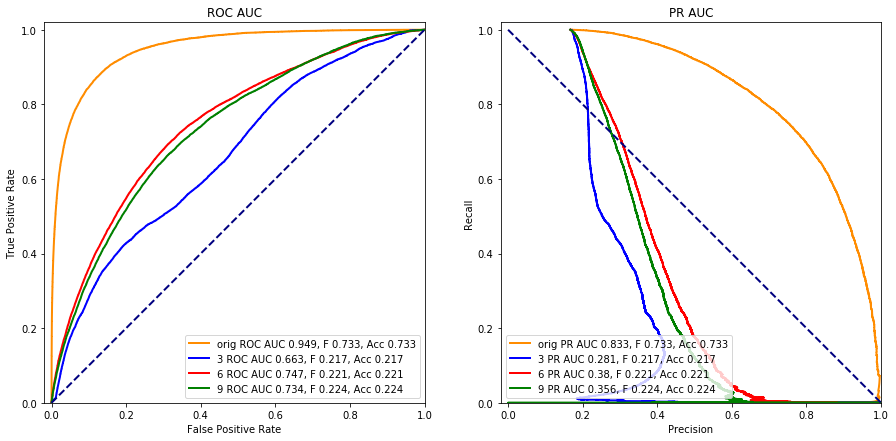

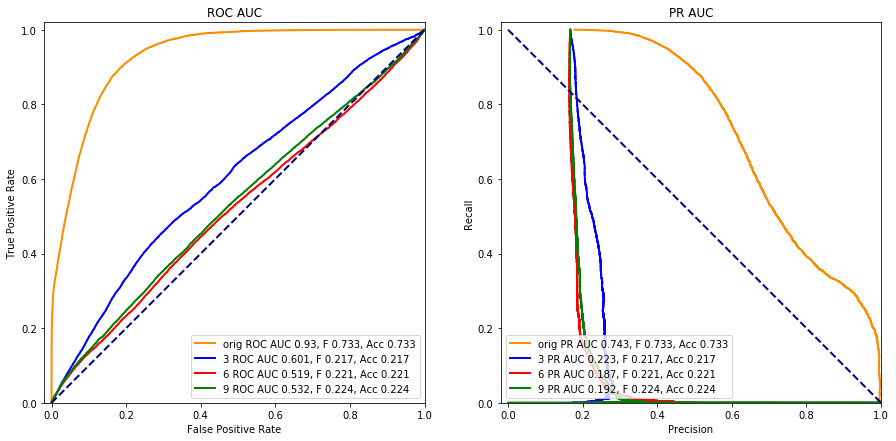

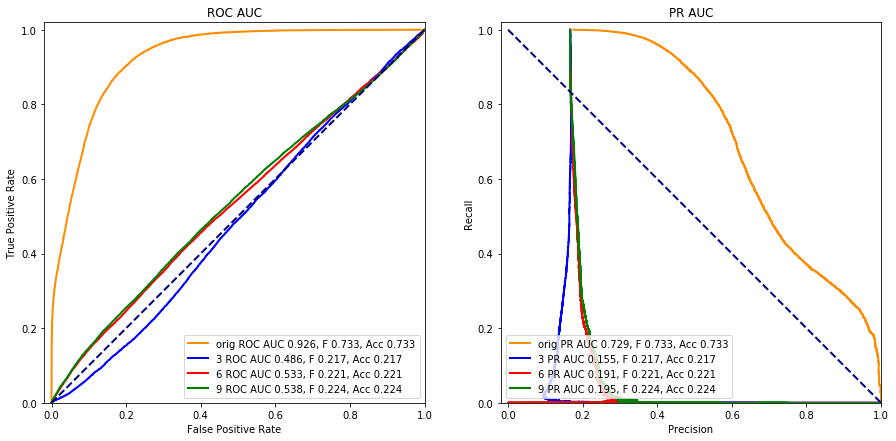




100%|██████████| 4/4 [03:51<00:00, 58.00s/it]




In [77]:
import os
for encoding_dim in tqdm(["orig"] + l_encoding_dim):
    if encoding_dim == "orig":
        y_proba = clf.predict_proba(X_test)
        y_real = y_test
    else:
        y_proba = clf.predict_proba(samples[encoding_dim])
        y_real = samples_y[encoding_dim].ravel()
    y_pred = np.argmax(y_proba, axis=1)
    y_bin = label_binarize(y_real, classes=np.unique(y_real))
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_real):
        idx = np.where(y_real == pid_label)[0]
        cur_y = np.where(y_real == pid_label, np.ones_like(y_real), np.zeros_like(y_real))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
        metrics_dict['roc_auc'][encoding_dim][pid_label] = auc(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label])
        metrics_dict['pr_auc'][encoding_dim][pid_label] = average_precision_score(cur_y.ravel(), cur_y_proba.ravel())
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_real, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_real, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='0', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='1', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='2', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='3', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='4', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='5', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     fig.savefig('./plots/{}_dim_{}.png'.format(MODEL_NAME, encoding_dim))

------------------